# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [64]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

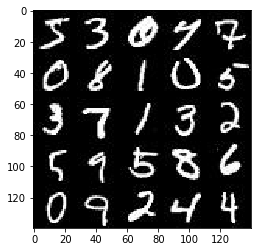

In [65]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

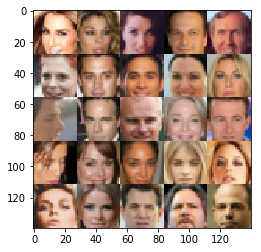

In [66]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [67]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [68]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [69]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha=0.2
    keep_probability = 0.8
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer 1
        # 28x28
        h1 = tf.layers.conv2d(images, 128, 5, strides=2, padding="same", 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        h1 = tf.nn.dropout(h1, keep_probability)
        lrelu1 = tf.maximum(alpha * h1, h1)
        
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d(lrelu1, 256, 5, strides=1, padding="same", 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.nn.dropout(h2, keep_probability)
        bn2 = tf.layers.batch_normalization(h2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d(lrelu2, 512, 3, strides=2, padding="same", 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        h3 = tf.nn.dropout(h3, keep_probability)
        bn3 = tf.layers.batch_normalization(h3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        
        #Flatten
        flat = tf.reshape(lrelu3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [70]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.2
    keep_probability = 0.5
    
    with tf.variable_scope('generator', reuse=not is_train):
        h1 = tf.layers.dense(z, 3*3*512)
        h1 = tf.reshape(h1, (-1, 3, 3, 512))
        bn1 = tf.layers.batch_normalization(h1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        # 3x3x256
        
        h2 = tf.layers.conv2d_transpose(lrelu1, 256, 3, strides=2, padding="same", 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.nn.dropout(h2, keep_probability)
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 6x6x128
        
        h3 = tf.layers.conv2d_transpose(lrelu2, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        h3 = tf.nn.dropout(h3, keep_probability)
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 12x12x64
        
        h4 = tf.layers.conv2d_transpose(lrelu3, 32, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        h4 = tf.nn.dropout(h4, keep_probability)
        bn4 = tf.layers.batch_normalization(h4, training=is_train)
        lrelu4 = tf.maximum(alpha * bn4, bn4)
        # 24x24x32
        
        # Output layer, 28x28xOut_channel_dim
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, strides=1, padding="valid")
        out = tf.tanh(logits)
       
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [71]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [72]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [73]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [74]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    if (data_image_mode == "L"):
        out_channel_dim=1
    else:
        out_channel_dim=3
    
    #tf.reset_default_graph()
    # model_inputs(image_width, image_height, image_channels, z_dim)
    input_real, input_z, lrate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lrate = learning_rate
    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lrate, beta1)
    
    print_on = 30
    show_on = 300
    samples, losses = [], []
    steps=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                batch_z=np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_on == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs), 
                          "D-Loss: {:.4f} ...".format(train_loss_d),
                          "G-Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_on == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                    

        show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... D-Loss: 0.6562 ... G-Loss: 3.7838
Epoch 1/2... D-Loss: 0.5614 ... G-Loss: 2.6289
Epoch 1/2... D-Loss: 0.7683 ... G-Loss: 2.7596
Epoch 1/2... D-Loss: 1.5671 ... G-Loss: 4.5117
Epoch 1/2... D-Loss: 0.5688 ... G-Loss: 3.1756
Epoch 1/2... D-Loss: 0.7033 ... G-Loss: 2.8863
Epoch 1/2... D-Loss: 0.9744 ... G-Loss: 1.8233
Epoch 1/2... D-Loss: 0.6215 ... G-Loss: 3.0389
Epoch 1/2... D-Loss: 0.8448 ... G-Loss: 4.1283
Epoch 1/2... D-Loss: 0.6468 ... G-Loss: 2.5493


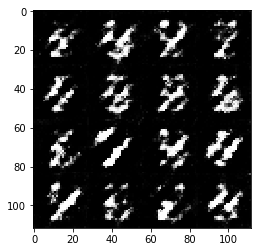

Epoch 1/2... D-Loss: 0.6289 ... G-Loss: 2.3665
Epoch 1/2... D-Loss: 0.5921 ... G-Loss: 2.5016
Epoch 1/2... D-Loss: 1.5563 ... G-Loss: 2.9431
Epoch 1/2... D-Loss: 0.8065 ... G-Loss: 2.5803
Epoch 1/2... D-Loss: 0.8127 ... G-Loss: 1.9377
Epoch 1/2... D-Loss: 0.6536 ... G-Loss: 2.0719
Epoch 1/2... D-Loss: 0.7031 ... G-Loss: 2.3015
Epoch 1/2... D-Loss: 0.7544 ... G-Loss: 2.1194
Epoch 1/2... D-Loss: 0.8734 ... G-Loss: 1.8799
Epoch 1/2... D-Loss: 0.6967 ... G-Loss: 2.3162


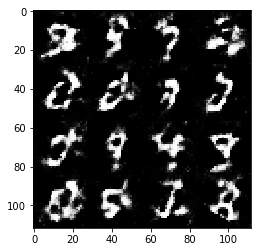

Epoch 1/2... D-Loss: 0.9870 ... G-Loss: 0.9559
Epoch 1/2... D-Loss: 1.0085 ... G-Loss: 1.3119
Epoch 1/2... D-Loss: 0.9366 ... G-Loss: 1.1896
Epoch 1/2... D-Loss: 0.8286 ... G-Loss: 1.6832
Epoch 1/2... D-Loss: 1.0847 ... G-Loss: 2.7337
Epoch 1/2... D-Loss: 1.2761 ... G-Loss: 1.0998
Epoch 1/2... D-Loss: 0.9022 ... G-Loss: 1.3105
Epoch 1/2... D-Loss: 0.8239 ... G-Loss: 2.0764
Epoch 1/2... D-Loss: 1.3519 ... G-Loss: 1.9744
Epoch 1/2... D-Loss: 0.9709 ... G-Loss: 1.7245


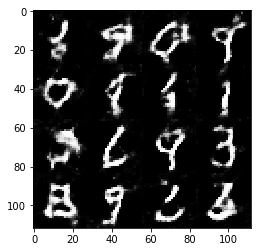

Epoch 1/2... D-Loss: 0.9459 ... G-Loss: 1.3632
Epoch 2/2... D-Loss: 0.8798 ... G-Loss: 1.4780
Epoch 2/2... D-Loss: 0.9951 ... G-Loss: 1.3201
Epoch 2/2... D-Loss: 0.7651 ... G-Loss: 2.6418
Epoch 2/2... D-Loss: 0.7257 ... G-Loss: 1.8393
Epoch 2/2... D-Loss: 0.9859 ... G-Loss: 1.4847
Epoch 2/2... D-Loss: 0.8382 ... G-Loss: 1.5962
Epoch 2/2... D-Loss: 0.9489 ... G-Loss: 2.2256
Epoch 2/2... D-Loss: 1.1465 ... G-Loss: 1.0923
Epoch 2/2... D-Loss: 0.9609 ... G-Loss: 0.9811


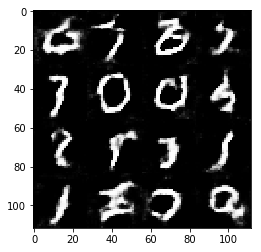

Epoch 2/2... D-Loss: 1.0664 ... G-Loss: 1.1806
Epoch 2/2... D-Loss: 0.8663 ... G-Loss: 1.6820
Epoch 2/2... D-Loss: 0.9496 ... G-Loss: 1.7511
Epoch 2/2... D-Loss: 1.5188 ... G-Loss: 2.4657
Epoch 2/2... D-Loss: 1.2243 ... G-Loss: 0.7879
Epoch 2/2... D-Loss: 0.9550 ... G-Loss: 2.5452
Epoch 2/2... D-Loss: 0.9516 ... G-Loss: 1.2041
Epoch 2/2... D-Loss: 0.7334 ... G-Loss: 1.9280
Epoch 2/2... D-Loss: 0.8798 ... G-Loss: 1.3649
Epoch 2/2... D-Loss: 0.8774 ... G-Loss: 1.4185


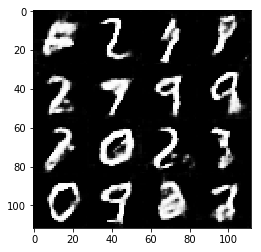

Epoch 2/2... D-Loss: 0.7593 ... G-Loss: 1.5868
Epoch 2/2... D-Loss: 0.8758 ... G-Loss: 1.9921
Epoch 2/2... D-Loss: 1.0301 ... G-Loss: 1.5732
Epoch 2/2... D-Loss: 0.9531 ... G-Loss: 1.9147
Epoch 2/2... D-Loss: 0.9183 ... G-Loss: 1.3124
Epoch 2/2... D-Loss: 0.7003 ... G-Loss: 2.0731
Epoch 2/2... D-Loss: 1.0710 ... G-Loss: 1.0732
Epoch 2/2... D-Loss: 0.9332 ... G-Loss: 1.2825
Epoch 2/2... D-Loss: 0.9728 ... G-Loss: 2.1179
Epoch 2/2... D-Loss: 0.8362 ... G-Loss: 1.5140


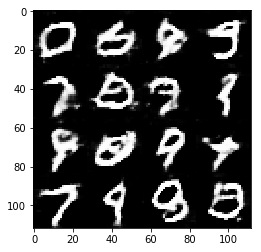

Epoch 2/2... D-Loss: 0.7258 ... G-Loss: 1.7356
Epoch 2/2... D-Loss: 0.7682 ... G-Loss: 1.7211


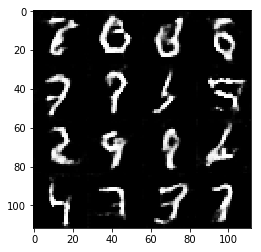

In [75]:
batch_size = 64
z_dim = 200
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... D-Loss: 0.5051 ... G-Loss: 2.8396
Epoch 1/1... D-Loss: 0.4489 ... G-Loss: 3.8480
Epoch 1/1... D-Loss: 0.5854 ... G-Loss: 2.1260
Epoch 1/1... D-Loss: 0.4572 ... G-Loss: 3.6716
Epoch 1/1... D-Loss: 0.4709 ... G-Loss: 3.3302
Epoch 1/1... D-Loss: 0.4752 ... G-Loss: 3.5617
Epoch 1/1... D-Loss: 0.7092 ... G-Loss: 4.6905
Epoch 1/1... D-Loss: 0.3974 ... G-Loss: 4.3899
Epoch 1/1... D-Loss: 0.4779 ... G-Loss: 3.4879
Epoch 1/1... D-Loss: 0.4129 ... G-Loss: 4.0765


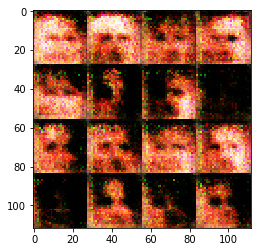

Epoch 1/1... D-Loss: 0.4418 ... G-Loss: 3.3140
Epoch 1/1... D-Loss: 0.4994 ... G-Loss: 2.7867
Epoch 1/1... D-Loss: 0.4245 ... G-Loss: 7.2501
Epoch 1/1... D-Loss: 0.4498 ... G-Loss: 3.5340
Epoch 1/1... D-Loss: 0.4512 ... G-Loss: 4.0449
Epoch 1/1... D-Loss: 0.4129 ... G-Loss: 4.5197
Epoch 1/1... D-Loss: 0.5267 ... G-Loss: 3.8140
Epoch 1/1... D-Loss: 0.4723 ... G-Loss: 2.7716
Epoch 1/1... D-Loss: 0.4628 ... G-Loss: 3.2902
Epoch 1/1... D-Loss: 0.4790 ... G-Loss: 3.3686


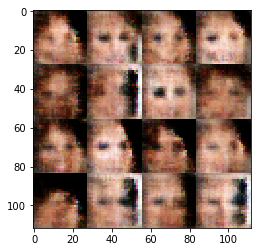

Epoch 1/1... D-Loss: 0.5040 ... G-Loss: 3.1671
Epoch 1/1... D-Loss: 0.4499 ... G-Loss: 3.5380
Epoch 1/1... D-Loss: 0.4106 ... G-Loss: 4.2463
Epoch 1/1... D-Loss: 0.3996 ... G-Loss: 4.3251
Epoch 1/1... D-Loss: 0.4132 ... G-Loss: 4.7806
Epoch 1/1... D-Loss: 0.5127 ... G-Loss: 2.6586
Epoch 1/1... D-Loss: 0.5923 ... G-Loss: 3.2477
Epoch 1/1... D-Loss: 0.5157 ... G-Loss: 2.8470
Epoch 1/1... D-Loss: 0.5926 ... G-Loss: 2.0905
Epoch 1/1... D-Loss: 0.5445 ... G-Loss: 3.2039


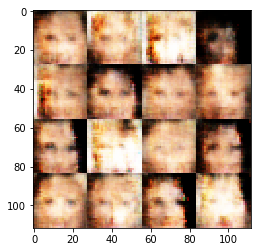

Epoch 1/1... D-Loss: 0.4958 ... G-Loss: 4.2067
Epoch 1/1... D-Loss: 0.8754 ... G-Loss: 1.2958
Epoch 1/1... D-Loss: 0.7447 ... G-Loss: 1.5327
Epoch 1/1... D-Loss: 0.5085 ... G-Loss: 3.3369
Epoch 1/1... D-Loss: 0.6127 ... G-Loss: 2.1549
Epoch 1/1... D-Loss: 0.6796 ... G-Loss: 1.7440
Epoch 1/1... D-Loss: 0.7981 ... G-Loss: 1.7143
Epoch 1/1... D-Loss: 0.5199 ... G-Loss: 2.7680
Epoch 1/1... D-Loss: 0.6407 ... G-Loss: 4.0957
Epoch 1/1... D-Loss: 0.6262 ... G-Loss: 2.1617


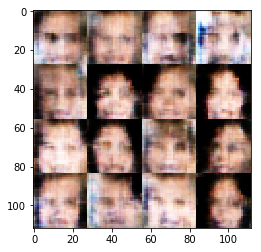

Epoch 1/1... D-Loss: 0.5696 ... G-Loss: 2.8917
Epoch 1/1... D-Loss: 0.6845 ... G-Loss: 1.8642
Epoch 1/1... D-Loss: 0.5115 ... G-Loss: 3.4816
Epoch 1/1... D-Loss: 0.5412 ... G-Loss: 3.3832
Epoch 1/1... D-Loss: 0.5772 ... G-Loss: 3.2691
Epoch 1/1... D-Loss: 0.6769 ... G-Loss: 2.2220
Epoch 1/1... D-Loss: 0.8305 ... G-Loss: 1.6625
Epoch 1/1... D-Loss: 0.6739 ... G-Loss: 1.9337
Epoch 1/1... D-Loss: 0.6948 ... G-Loss: 3.3678
Epoch 1/1... D-Loss: 0.5309 ... G-Loss: 3.1006


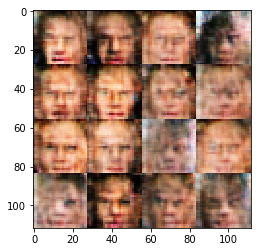

Epoch 1/1... D-Loss: 0.7735 ... G-Loss: 1.6589
Epoch 1/1... D-Loss: 0.6260 ... G-Loss: 2.3088
Epoch 1/1... D-Loss: 0.5041 ... G-Loss: 2.7945
Epoch 1/1... D-Loss: 0.5045 ... G-Loss: 3.5761
Epoch 1/1... D-Loss: 0.7851 ... G-Loss: 2.3296
Epoch 1/1... D-Loss: 0.7159 ... G-Loss: 1.9866
Epoch 1/1... D-Loss: 0.5982 ... G-Loss: 2.4122
Epoch 1/1... D-Loss: 0.6643 ... G-Loss: 2.0057
Epoch 1/1... D-Loss: 0.6908 ... G-Loss: 2.4519
Epoch 1/1... D-Loss: 0.7267 ... G-Loss: 1.9825


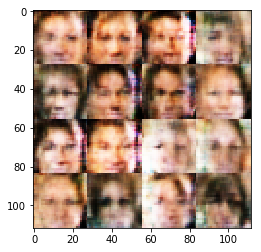

Epoch 1/1... D-Loss: 0.7365 ... G-Loss: 2.1393
Epoch 1/1... D-Loss: 0.7064 ... G-Loss: 2.2072
Epoch 1/1... D-Loss: 0.5846 ... G-Loss: 2.4577
Epoch 1/1... D-Loss: 0.5986 ... G-Loss: 2.4145
Epoch 1/1... D-Loss: 0.5864 ... G-Loss: 2.4763
Epoch 1/1... D-Loss: 0.4891 ... G-Loss: 2.3617
Epoch 1/1... D-Loss: 0.6067 ... G-Loss: 3.0638
Epoch 1/1... D-Loss: 0.6320 ... G-Loss: 2.4110
Epoch 1/1... D-Loss: 0.6982 ... G-Loss: 2.5781
Epoch 1/1... D-Loss: 0.9068 ... G-Loss: 1.3455


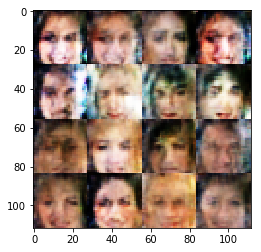

Epoch 1/1... D-Loss: 0.7043 ... G-Loss: 2.1925
Epoch 1/1... D-Loss: 0.6432 ... G-Loss: 2.2972
Epoch 1/1... D-Loss: 0.6549 ... G-Loss: 3.0765
Epoch 1/1... D-Loss: 0.5676 ... G-Loss: 2.5789
Epoch 1/1... D-Loss: 0.5809 ... G-Loss: 2.1442
Epoch 1/1... D-Loss: 0.6621 ... G-Loss: 2.1028
Epoch 1/1... D-Loss: 0.6457 ... G-Loss: 2.7217
Epoch 1/1... D-Loss: 0.7116 ... G-Loss: 1.9439
Epoch 1/1... D-Loss: 0.5689 ... G-Loss: 2.6927
Epoch 1/1... D-Loss: 0.7328 ... G-Loss: 2.1953


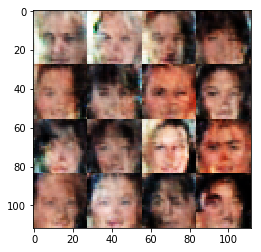

Epoch 1/1... D-Loss: 0.6417 ... G-Loss: 2.4630
Epoch 1/1... D-Loss: 0.6140 ... G-Loss: 3.1649
Epoch 1/1... D-Loss: 0.7140 ... G-Loss: 2.9788
Epoch 1/1... D-Loss: 0.6925 ... G-Loss: 3.2964
Epoch 1/1... D-Loss: 0.6963 ... G-Loss: 2.8312
Epoch 1/1... D-Loss: 0.5465 ... G-Loss: 3.1758
Epoch 1/1... D-Loss: 0.6044 ... G-Loss: 2.6656
Epoch 1/1... D-Loss: 0.7174 ... G-Loss: 2.1962
Epoch 1/1... D-Loss: 0.6624 ... G-Loss: 2.2392
Epoch 1/1... D-Loss: 0.6240 ... G-Loss: 3.4858


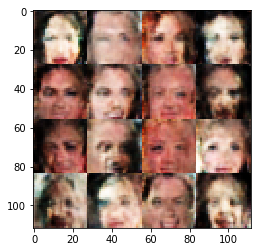

Epoch 1/1... D-Loss: 0.7143 ... G-Loss: 1.9606
Epoch 1/1... D-Loss: 0.6183 ... G-Loss: 2.1943
Epoch 1/1... D-Loss: 0.6684 ... G-Loss: 1.9595
Epoch 1/1... D-Loss: 0.6364 ... G-Loss: 2.5533
Epoch 1/1... D-Loss: 0.6359 ... G-Loss: 2.0317
Epoch 1/1... D-Loss: 0.6620 ... G-Loss: 2.2913
Epoch 1/1... D-Loss: 0.7600 ... G-Loss: 2.4171
Epoch 1/1... D-Loss: 0.5715 ... G-Loss: 3.3937
Epoch 1/1... D-Loss: 0.7631 ... G-Loss: 1.6264
Epoch 1/1... D-Loss: 0.5496 ... G-Loss: 3.6167


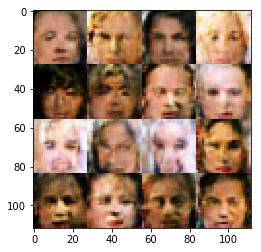

Epoch 1/1... D-Loss: 0.6267 ... G-Loss: 2.3546
Epoch 1/1... D-Loss: 0.5613 ... G-Loss: 3.0421
Epoch 1/1... D-Loss: 0.6596 ... G-Loss: 2.2662
Epoch 1/1... D-Loss: 0.7203 ... G-Loss: 1.6040
Epoch 1/1... D-Loss: 0.8862 ... G-Loss: 1.7662
Epoch 1/1... D-Loss: 0.6422 ... G-Loss: 2.0955
Epoch 1/1... D-Loss: 0.7914 ... G-Loss: 3.4984
Epoch 1/1... D-Loss: 0.7515 ... G-Loss: 3.2586
Epoch 1/1... D-Loss: 0.9465 ... G-Loss: 1.4044
Epoch 1/1... D-Loss: 0.6006 ... G-Loss: 2.6860


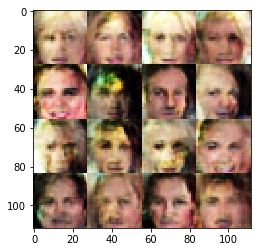

Epoch 1/1... D-Loss: 1.0492 ... G-Loss: 1.3628
Epoch 1/1... D-Loss: 0.5515 ... G-Loss: 3.2670
Epoch 1/1... D-Loss: 0.7720 ... G-Loss: 2.1713
Epoch 1/1... D-Loss: 1.5931 ... G-Loss: 0.7889
Epoch 1/1... D-Loss: 0.7867 ... G-Loss: 1.9694
Epoch 1/1... D-Loss: 0.6821 ... G-Loss: 2.1847
Epoch 1/1... D-Loss: 0.6555 ... G-Loss: 3.1655
Epoch 1/1... D-Loss: 0.5674 ... G-Loss: 2.5168
Epoch 1/1... D-Loss: 0.5366 ... G-Loss: 3.0182
Epoch 1/1... D-Loss: 0.5257 ... G-Loss: 3.0055


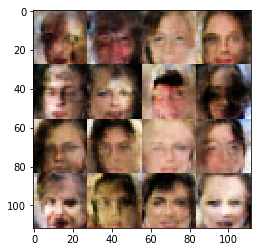

Epoch 1/1... D-Loss: 0.7105 ... G-Loss: 1.7482
Epoch 1/1... D-Loss: 0.5536 ... G-Loss: 2.9059
Epoch 1/1... D-Loss: 0.6228 ... G-Loss: 2.3436
Epoch 1/1... D-Loss: 0.6399 ... G-Loss: 3.1345
Epoch 1/1... D-Loss: 0.6875 ... G-Loss: 2.4346
Epoch 1/1... D-Loss: 0.6567 ... G-Loss: 2.2394
Epoch 1/1... D-Loss: 0.9098 ... G-Loss: 3.7018
Epoch 1/1... D-Loss: 0.7030 ... G-Loss: 1.6393
Epoch 1/1... D-Loss: 0.5985 ... G-Loss: 2.4454
Epoch 1/1... D-Loss: 0.4844 ... G-Loss: 2.9256


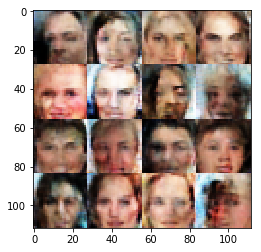

Epoch 1/1... D-Loss: 0.5663 ... G-Loss: 2.8778
Epoch 1/1... D-Loss: 0.8029 ... G-Loss: 1.6661
Epoch 1/1... D-Loss: 0.6965 ... G-Loss: 2.4692
Epoch 1/1... D-Loss: 0.9833 ... G-Loss: 1.1206
Epoch 1/1... D-Loss: 0.6080 ... G-Loss: 2.0351
Epoch 1/1... D-Loss: 0.6668 ... G-Loss: 1.8015
Epoch 1/1... D-Loss: 0.6091 ... G-Loss: 1.9806
Epoch 1/1... D-Loss: 0.8323 ... G-Loss: 1.7502
Epoch 1/1... D-Loss: 0.7332 ... G-Loss: 2.4527
Epoch 1/1... D-Loss: 0.5925 ... G-Loss: 2.0512


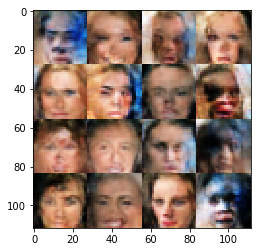

Epoch 1/1... D-Loss: 0.5673 ... G-Loss: 3.0344
Epoch 1/1... D-Loss: 0.6899 ... G-Loss: 2.4037
Epoch 1/1... D-Loss: 0.7596 ... G-Loss: 2.3725
Epoch 1/1... D-Loss: 1.0095 ... G-Loss: 0.9202
Epoch 1/1... D-Loss: 0.7120 ... G-Loss: 1.9152
Epoch 1/1... D-Loss: 0.6775 ... G-Loss: 2.8003
Epoch 1/1... D-Loss: 0.6206 ... G-Loss: 3.1227
Epoch 1/1... D-Loss: 0.6989 ... G-Loss: 2.3077
Epoch 1/1... D-Loss: 0.6077 ... G-Loss: 2.0992
Epoch 1/1... D-Loss: 0.6895 ... G-Loss: 2.1258


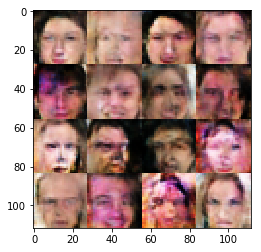

Epoch 1/1... D-Loss: 0.7170 ... G-Loss: 2.4324
Epoch 1/1... D-Loss: 0.7325 ... G-Loss: 1.5094
Epoch 1/1... D-Loss: 0.5127 ... G-Loss: 2.9772
Epoch 1/1... D-Loss: 0.7916 ... G-Loss: 2.8231
Epoch 1/1... D-Loss: 0.6467 ... G-Loss: 2.1438
Epoch 1/1... D-Loss: 0.6658 ... G-Loss: 3.3690
Epoch 1/1... D-Loss: 0.6894 ... G-Loss: 1.8893
Epoch 1/1... D-Loss: 0.6996 ... G-Loss: 3.1908
Epoch 1/1... D-Loss: 0.8765 ... G-Loss: 3.0987
Epoch 1/1... D-Loss: 0.5340 ... G-Loss: 2.4129


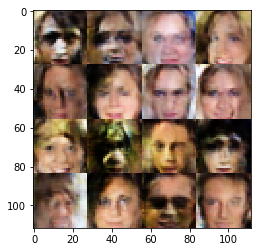

Epoch 1/1... D-Loss: 0.8362 ... G-Loss: 3.4299
Epoch 1/1... D-Loss: 0.7161 ... G-Loss: 1.9015
Epoch 1/1... D-Loss: 0.5390 ... G-Loss: 2.8381
Epoch 1/1... D-Loss: 0.7506 ... G-Loss: 2.6068
Epoch 1/1... D-Loss: 0.4777 ... G-Loss: 2.5209
Epoch 1/1... D-Loss: 0.5810 ... G-Loss: 2.7542
Epoch 1/1... D-Loss: 0.7953 ... G-Loss: 1.5911
Epoch 1/1... D-Loss: 0.5507 ... G-Loss: 3.1798
Epoch 1/1... D-Loss: 0.6483 ... G-Loss: 2.5987
Epoch 1/1... D-Loss: 0.7148 ... G-Loss: 2.2554


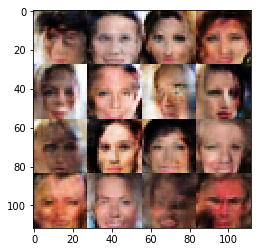

Epoch 1/1... D-Loss: 0.6778 ... G-Loss: 2.6206
Epoch 1/1... D-Loss: 0.6560 ... G-Loss: 2.2384
Epoch 1/1... D-Loss: 0.5079 ... G-Loss: 2.4282
Epoch 1/1... D-Loss: 0.6029 ... G-Loss: 3.0808
Epoch 1/1... D-Loss: 0.6909 ... G-Loss: 2.5905
Epoch 1/1... D-Loss: 0.6312 ... G-Loss: 2.1205
Epoch 1/1... D-Loss: 0.5892 ... G-Loss: 2.3775
Epoch 1/1... D-Loss: 0.9181 ... G-Loss: 1.3017
Epoch 1/1... D-Loss: 0.6175 ... G-Loss: 2.5981
Epoch 1/1... D-Loss: 0.7176 ... G-Loss: 1.5618


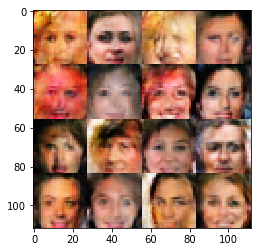

Epoch 1/1... D-Loss: 0.5456 ... G-Loss: 1.9995
Epoch 1/1... D-Loss: 0.7118 ... G-Loss: 2.8187
Epoch 1/1... D-Loss: 0.5806 ... G-Loss: 2.3853
Epoch 1/1... D-Loss: 0.5623 ... G-Loss: 2.3525
Epoch 1/1... D-Loss: 0.6614 ... G-Loss: 2.9448
Epoch 1/1... D-Loss: 0.5168 ... G-Loss: 2.5441
Epoch 1/1... D-Loss: 0.7703 ... G-Loss: 1.5164
Epoch 1/1... D-Loss: 0.7036 ... G-Loss: 1.9112
Epoch 1/1... D-Loss: 0.5259 ... G-Loss: 3.1963
Epoch 1/1... D-Loss: 0.6868 ... G-Loss: 2.2667


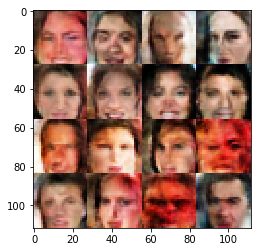

Epoch 1/1... D-Loss: 0.7303 ... G-Loss: 2.3368
Epoch 1/1... D-Loss: 0.7359 ... G-Loss: 2.2886
Epoch 1/1... D-Loss: 0.6436 ... G-Loss: 2.2741
Epoch 1/1... D-Loss: 0.6757 ... G-Loss: 2.4313
Epoch 1/1... D-Loss: 0.5768 ... G-Loss: 2.6599
Epoch 1/1... D-Loss: 0.6644 ... G-Loss: 2.9472
Epoch 1/1... D-Loss: 0.5402 ... G-Loss: 3.3597
Epoch 1/1... D-Loss: 0.7465 ... G-Loss: 2.0873
Epoch 1/1... D-Loss: 0.6246 ... G-Loss: 2.3086
Epoch 1/1... D-Loss: 0.7701 ... G-Loss: 2.0223


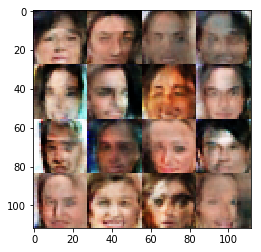

Epoch 1/1... D-Loss: 0.7420 ... G-Loss: 1.6304
Epoch 1/1... D-Loss: 0.5746 ... G-Loss: 2.8202
Epoch 1/1... D-Loss: 0.6680 ... G-Loss: 2.8490
Epoch 1/1... D-Loss: 0.9404 ... G-Loss: 1.3067
Epoch 1/1... D-Loss: 0.5181 ... G-Loss: 3.0536
Epoch 1/1... D-Loss: 0.6391 ... G-Loss: 3.0844
Epoch 1/1... D-Loss: 0.8291 ... G-Loss: 1.2696
Epoch 1/1... D-Loss: 0.6366 ... G-Loss: 2.3202
Epoch 1/1... D-Loss: 0.6401 ... G-Loss: 3.3873
Epoch 1/1... D-Loss: 0.6427 ... G-Loss: 2.0043


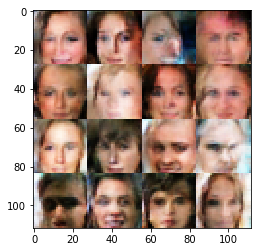

Epoch 1/1... D-Loss: 0.5774 ... G-Loss: 2.5328


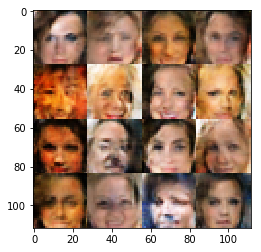

In [76]:
batch_size = 64
z_dim = 200
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.